# Adding projection and geotransform metadata to netcdf file

This notebook builds on the ideas that Bryce Nordgren posted to

http://nbviewer.ipython.org/gist/bnordgren/47eee80aae57deb303a0

Basically, we found that Bryce's changes were still not sufficient to produce the gdalinfo metadata we expected to see, nor to geolocate the geotiff file he produced using ArcGIS.  gdalinfo run on the file he created was missing values for origin and pixel size that we expect to see after the Coordinate System, and was returning incorrect corner points:

    Corner Coordinates:
    Upper Left  (    0.0,    0.0)
    Lower Left  (    0.0,  180.0)
    Right (  180.0,    0.0)
    Lower Right (  180.0,  180.0)
    Center      (   90.0,   90.0)


Also, the gdal drivers were having a problem understanding the row orientation, and Bryce's file required that "--config GDAL_NETCDF_BOTTOMUP NO" be included to gdal_translate calls to override the confusion.

I believe I have figured out the correct way to alter the snow cover .nc files so that:
1. gdal utilities will not require the BOTTOMUP override, 
2. gdal_translate produces geotiffs that are interpreted correctly by ENVI (5.2) and ArcMap (v10.1), and
3. gdalinfo on the new .nc file and translated geotiffs produces correct geolocation metadata.

Like Bryce, I am working with this file:

ftp://sidads.colorado.edu/pub/DATASETS/nsidc0531_MEASURES_nhsnow_weekly100/2003/nhtsw100e2_20030107_20030113.nc

<i>N.B. Bryce observes that this file is "supposed to be in EASE-Grid 2.0 format."  To begin I would like to clarify that EASE-Grid 2.0 is not a file format.  EASE-Grid 2.0 is a projection definition.  Gridded data in EASE-Grid 2.0 can be stored in any file format, including flat binary, HDF, netCDF and geoTIFF.  There are three EASE-Grid 2.0 projections, which are all in the equal area family: the Lambert Azimuthal North and South and the global cylindrical equal-area projection (with true latitude at +/- 30 degrees).  EASE-Grid 2.0 is described in the following publication:

Brodzik, M. J., B. Billingsley, T. Haran, B. Raup, M. H. Savoie. 2012. <a href="http://www.mdpi.com/2220-9964/1/1/32/">EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets. </a>ISPRS International Journal of Geo-Information, 1(1):32-45, doi:10.3390/ijgi1010032.


and errata:

Brodzik, M. J., B. Billingsley, T. Haran, B. Raup, M. H. Savoie. 2014. <a href="http://www.mdpi.com/2220-9964/3/3/1154/">Correction: Brodzik, M. J. et al. EASE-Grid 2.0: Incremental but Significant Improvements for Earth-Gridded Data Sets. ISPRS International Journal of Geo-Information 2012, 1, 32-45.</a>ISPRS International Journal of Geo-Information, 3(3):1154-1156, doi:10.3390/ijgi3031154.

</i>



In [3]:
import mpl_toolkits.basemap.pyproj as pyproj
import netCDF4 as nc
import os
import numpy as np
from mpl_toolkits.basemap import Basemap
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
os.chdir("/Users/brodzik/ipython_notebooks/gdal_test/")
orig_basename = "nhtsw100e2_20030107_20030113"
test_basename = orig_basename + ".test"
call(["rm","-f",orig_basename + ".nc"])
call(["wget","ftp://sidads.colorado.edu/pub/DATASETS/nsidc0531_MEASURES_nhsnow_weekly100/2003/" + orig_basename + ".nc"])
call(["cp",orig_basename + ".nc",test_basename + ".nc"])

0

In [5]:
d = nc.Dataset(test_basename + ".nc", 'r+')
print d

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: nhtsw100e2_20030107_20030113.nc
    naming_authority: gov.nasa.eosdis
    reference: http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0531.001
    metadata_link: http://nsidc.org/api/metadata?id=nsidc-0531
    title: MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Weekly 100km EASE-Grid 2.0
    product_version: v01r00
    summary: This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from two independently produced sources.  Variables include snow cover extent from the weekly NOAA/NCDC Northern Hemisphere Snow Cover Extent Climate Data Record (NH SCE CDR) and a gap-filled snow extent product derived from the Special Sensor Microw

In [6]:
coords = d.variables['coord_system']
print coords

<type 'netCDF4._netCDF4.Variable'>
|S1 coord_system()
    comment: EASE-Grid-2.0 projection definition documention: http://nsidc.org/data/ease/ease_grid2.html, NSIDC mapx grid parameter definition file: EASE2_N100km.gpd, grid_id: EASE2_N100km
    grid_mapping_name: lambert_azimuthal_equal_area
    longitude_of_projection_origin: 0.0
    latitude_of_projection_origin: 90.0
    false_easting: 0.0
    false_northing: 0.0
    scale_factor_at_projection_origin: 25
    semimajor_axis: 6.37814e+06
    semiminor_axis: 6.35675e+06
    inverse_flattening: 298.257
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of   used



I believe Bryce was correct in stating that his problem was that row and column coordinate variables were missing.  Bryce outlined an empirical method for determining the values needed, but I know a couple of things about this projection, namely that the origin of the project is the North Pole, which is centered at the intersection of the 4 center cells.  The file level metadata is telling me that the resolution is 100 km.  

For the projected coordinate system, I assume a standard Cartesian coordinate system positioned at the origin, with X increasing to the right and Y increasing upward.  I also assume units are meters.  

In order to set the row and column coordinate values to the centers of each cell, I calculate the values for each axis by multiplying each cell index by the map scale (100000. m).  The offset of map_scale_x_meters/2 = 50000 m positions each value at the center of each cell.  

Note that I set the y_meters values to the reverse of the x_meters values.  This produces a cols coordinate variable reading from left to right, and a rows coordinate variable reading from top to bottom.

It is possible that reversing both the data array columns and this rows array will result in equivalent output, but I 
did not verify that.

In [7]:
map_scale_x_meters = 100000.
ncols = len(d.dimensions['cols'])
x_meters = ( np.arange(ncols) - (ncols/2) ) * map_scale_x_meters + (map_scale_x_meters/2)
x_meters = x_meters.astype(np.float32)
y_meters = x_meters[::-1]

# make the rows coordinate variable
# note the variable name is the same as the dimension name
# the standard_name set to 'projection_y_coordinate'
# is needed for gdal to understand the geolocation
rows_var = d.createVariable('rows',np.float32, ('rows',))

# give it the expected attributes
rows_var.standard_name = 'projection_y_coordinate'
rows_var.axis          = 'Y'
rows_var.units         = 'meters'

# write the values to the variable
rows_var[:] = y_meters
# make the cols coordinate variable similarly
cols_var = d.createVariable('cols',np.float32, ('cols',))
# give it the expected attributes
cols_var.standard_name = 'projection_x_coordinate'
cols_var.axis          = 'X'
cols_var.units         = 'meters'

# write the values to the dataset variable
cols_var[:] = x_meters

Examining what's in the dataset variable to confirm I have what I want 
(new coordinate variables rows and cols, and values I expect).

In [8]:
print d

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: nhtsw100e2_20030107_20030113.nc
    naming_authority: gov.nasa.eosdis
    reference: http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0531.001
    metadata_link: http://nsidc.org/api/metadata?id=nsidc-0531
    title: MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Weekly 100km EASE-Grid 2.0
    product_version: v01r00
    summary: This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from two independently produced sources.  Variables include snow cover extent from the weekly NOAA/NCDC Northern Hemisphere Snow Cover Extent Climate Data Record (NH SCE CDR) and a gap-filled snow extent product derived from the Special Sensor Microw

In [9]:
print d.variables['rows'][::]

[ 8950000.  8850000.  8750000.  8650000.  8550000.  8450000.  8350000.
  8250000.  8150000.  8050000.  7950000.  7850000.  7750000.  7650000.
  7550000.  7450000.  7350000.  7250000.  7150000.  7050000.  6950000.
  6850000.  6750000.  6650000.  6550000.  6450000.  6350000.  6250000.
  6150000.  6050000.  5950000.  5850000.  5750000.  5650000.  5550000.
  5450000.  5350000.  5250000.  5150000.  5050000.  4950000.  4850000.
  4750000.  4650000.  4550000.  4450000.  4350000.  4250000.  4150000.
  4050000.  3950000.  3850000.  3750000.  3650000.  3550000.  3450000.
  3350000.  3250000.  3150000.  3050000.  2950000.  2850000.  2750000.
  2650000.  2550000.  2450000.  2350000.  2250000.  2150000.  2050000.
  1950000.  1850000.  1750000.  1650000.  1550000.  1450000.  1350000.
  1250000.  1150000.  1050000.   950000.   850000.   750000.   650000.
   550000.   450000.   350000.   250000.   150000.    50000.   -50000.
  -150000.  -250000.  -350000.  -450000.  -550000.  -650000.  -750000.
  -850

In [10]:
print d.variables['cols'][::]

[-8950000. -8850000. -8750000. -8650000. -8550000. -8450000. -8350000.
 -8250000. -8150000. -8050000. -7950000. -7850000. -7750000. -7650000.
 -7550000. -7450000. -7350000. -7250000. -7150000. -7050000. -6950000.
 -6850000. -6750000. -6650000. -6550000. -6450000. -6350000. -6250000.
 -6150000. -6050000. -5950000. -5850000. -5750000. -5650000. -5550000.
 -5450000. -5350000. -5250000. -5150000. -5050000. -4950000. -4850000.
 -4750000. -4650000. -4550000. -4450000. -4350000. -4250000. -4150000.
 -4050000. -3950000. -3850000. -3750000. -3650000. -3550000. -3450000.
 -3350000. -3250000. -3150000. -3050000. -2950000. -2850000. -2750000.
 -2650000. -2550000. -2450000. -2350000. -2250000. -2150000. -2050000.
 -1950000. -1850000. -1750000. -1650000. -1550000. -1450000. -1350000.
 -1250000. -1150000. -1050000.  -950000.  -850000.  -750000.  -650000.
  -550000.  -450000.  -350000.  -250000.  -150000.   -50000.    50000.
   150000.   250000.   350000.   450000.   550000.   650000.   750000.
   850

In [11]:
d.close()
print "Done"

Done


## Here is the gdalinfo output on the test .nc file

Note the output indicates a Coordinate System, origin, Pixel Size and the Corner Coordinates are correct.

<pre>
vagrant@vmeltingsledge:~/ipython_notebooks/gdal_test$ gdalinfo NETCDF:nhtsw100e2_20030107_20030113.test.nc:merged_snow_cover_extent
Driver: netCDF/Network Common Data Format
Files: none associated
Size is 180, 180
Coordinate System is:
PROJCS["LAEA (WGS84) ",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            TOWGS84[0,0,0,0,0,0,0],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9108"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0]]
Origin = (-9000000.000000000000000,9000000.000000000000000)
Pixel Size = (100000.000000000000000,-100000.000000000000000)
Metadata:
  cols#axis=X
  cols#standard_name=projection_x_coordinate
  cols#units=meters
  coord_system#comment=EASE-Grid-2.0 projection definition documention: http://nsidc.org/data/ease/ease_grid2.html, NSIDC mapx grid parameter definition file: EASE2_N100km.gpd, grid_id: EASE2_N100km
  coord_system#false_easting=0
  coord_system#false_northing=0
  coord_system#grid_mapping_name=lambert_azimuthal_equal_area
  coord_system#inverse_flattening=298.25723
  coord_system#latitude_of_projection_origin=90
  coord_system#longitude_of_projection_origin=0
  coord_system#scale_factor_at_projection_origin=25
  coord_system#semimajor_axis=6378137
  coord_system#semiminor_axis=6356752.5
  merged_snow_cover_extent#_FillValue=-99
  merged_snow_cover_extent#comment=10: Snow cover reported by weekly_cdr, passive_microwave, 11: Snow cover reported by weekly_cdr only,  12: Snow cover reported by passive_microwave only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
  merged_snow_cover_extent#coordinates=longitude latitude time
  merged_snow_cover_extent#flag_meanings=cdr_microwave_report_snow cdr_only_reports_snow microwave_only_reports_snow snow_free_land permanent_ice ocean
  merged_snow_cover_extent#flag_values={10,11,12,20,30,40}
  merged_snow_cover_extent#grid_mapping=coord_system
  merged_snow_cover_extent#long_name=Merged Snow Cover Extent
  merged_snow_cover_extent#valid_range={10,40}
  NC_GLOBAL#cdm_data_type=Grid
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#date_created=2014-09-09T16:19:30Z
  NC_GLOBAL#geospatial_lat_max=90
  NC_GLOBAL#geospatial_lat_min=0
  NC_GLOBAL#geospatial_lat_units=degrees_north
  NC_GLOBAL#geospatial_lon_max=180
  NC_GLOBAL#geospatial_lon_min=-180
  NC_GLOBAL#geospatial_lon_units=degrees_east
  NC_GLOBAL#id=nhtsw100e2_20030107_20030113.nc
  NC_GLOBAL#institution=Center for Environmental Prediction, Rutgers University
  NC_GLOBAL#keywords=EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW COVER, EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SNOW/ICE > SNOW COVER
  NC_GLOBAL#keywords_vocabulary=NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 8.0
  NC_GLOBAL#license=No restrictions on access or use
  NC_GLOBAL#Metadata_Conventions=CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
  NC_GLOBAL#metadata_link=http://nsidc.org/api/metadata?id=nsidc-0531
  NC_GLOBAL#naming_authority=gov.nasa.eosdis
  NC_GLOBAL#platform=NOAA POES (Polar Orbiting Environmental Satellites), DMSP (Defense Meteorological Satellite Program), GOES (Geostationary Operational Environmental Satellite), METEOSAT, GMS (Japan Geostationary Meteorological Satellite), METOP, TERRA > Earth Observing System TERRA (AM-1), AQUA > Earth Observing System AQUA
  NC_GLOBAL#product_version=v01r00
  NC_GLOBAL#reference=http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0531.001
  NC_GLOBAL#sensor=VISSR > Visible and Infrared Spin Scan Radiometer, VAS > VISSR Atmospheric Sounder, MODIS > Moderate-Resolution Imaging Spectroradiometer, AMSU-B > Advanced Microwave Sounding Unit-B, AMSR-E > Advanced Microwave Scanning Radiometer-EOS, SSMI > Special Sensor Microwave/Imager, SSMIS > Special Sensor Microwave Imager/Sounder, VIIRS > Visible-Infrared Imager-Radiometer Suite
  NC_GLOBAL#source=ftp://data.ncdc.noaa.gov/cdr/snowcover/, ftp://sidads.colorado.edu/pub/DATASETS/nsidc0001_polar_stereo_tbs/
  NC_GLOBAL#spatial_resolution=100 km
  NC_GLOBAL#standard_name_vocabulary=CF Standard Name Table (v22, 12 February 2013)
  NC_GLOBAL#summary=This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from two independently produced sources.  Variables include snow cover extent from the weekly NOAA/NCDC Northern Hemisphere Snow Cover Extent Climate Data Record (NH SCE CDR) and a gap-filled snow extent product derived from the Special Sensor Microwave/Imager (SSMI) and Special Sensor Microwave Imager/Sounder (SSMIS).  The NSIDC Land-Ocean-Coast-Ice (LOCI) mask derived from BU-MODIS land cover data is consistently applied to each variable.  Data are in a Northern Hemisphere equal area projection at 100 km resolution, and are contained in weekly netCDF files spanning from October 4, 1966 to December 31, 2012.
  NC_GLOBAL#time_coverage_end=2003-01-13
  NC_GLOBAL#time_coverage_start=2003-01-07
  NC_GLOBAL#title=MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Weekly 100km EASE-Grid 2.0
  NETCDF_DIM_EXTRA={time}
  NETCDF_DIM_time_DEF={1,4}
  NETCDF_DIM_time_VALUES=13251
  rows#axis=Y
  rows#standard_name=projection_y_coordinate
  rows#units=meters
  time#axis=T
  time#calendar=gregorian
  time#long_name=time
  time#standard_name=time
  time#units=days since 1966-10-03
Geolocation:
  LINE_OFFSET=0
  LINE_STEP=1
  PIXEL_OFFSET=0
  PIXEL_STEP=1
  SRS=GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]]
  X_BAND=1
  X_DATASET=NETCDF:"nhtsw100e2_20030107_20030113.test.nc":longitude
  Y_BAND=1
  Y_DATASET=NETCDF:"nhtsw100e2_20030107_20030113.test.nc":latitude
Corner Coordinates:
Upper Left  (-9000000.000, 9000000.000) (135d 0' 0.00"W, 84d38' 2.58"S)
Lower Left  (-9000000.000,-9000000.000) ( 45d 0' 0.00"W, 84d38' 2.58"S)
Upper Right ( 9000000.000, 9000000.000) (135d 0' 0.00"E, 84d38' 2.58"S)
Lower Right ( 9000000.000,-9000000.000) ( 45d 0' 0.00"E, 84d38' 2.58"S)
Center      (   0.0000000,   0.0000000) (  0d 0' 0.01"E, 90d 0' 0.00"N)
Band 1 Block=180x180 Type=Byte, ColorInterp=Undefined
  NoData Value=-99
  Metadata:
    _FillValue=-99
    comment=10: Snow cover reported by weekly_cdr, passive_microwave, 11: Snow cover reported by weekly_cdr only,  12: Snow cover reported by passive_microwave only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
    coordinates=longitude latitude time
    flag_meanings=cdr_microwave_report_snow cdr_only_reports_snow microwave_only_reports_snow snow_free_land permanent_ice ocean
    flag_values={10,11,12,20,30,40}
    grid_mapping=coord_system
    long_name=Merged Snow Cover Extent
    NETCDF_DIM_time=13251
    NETCDF_VARNAME=merged_snow_cover_extent
    valid_range={10,40}
  Image Structure Metadata:
    PIXELTYPE=SIGNEDBYTE
   
</pre>

## Also, gdal_translate does not require the BOTTOMUP switch:

<pre>
vagrant@vsnowyski:~/ipynb$ gdal_translate -of GTiff -b 1 NETCDF:nhtsw100e2_20030107_20030113.test.nc:merged_snow_cover_extent snowcover.test.tif
Input file size is 180, 180
0...10...20...30...40...50...60...70...80...90...100 - done.
vagrant@vsnowyski:~/ipynb$ 
</pre>

## And here is what gdalinfo returns on the output tif file:

<pre>
vagrant@vmeltingsledge:~/ipython_notebooks/gdal_test$ gdalinfo snowcover.test.tif
Driver: GTiff/GeoTIFF
Files: snowcover.test.tif
Size is 180, 180
Coordinate System is:
PROJCS["LAEA (WGS84) ",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",90],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-9000000.000000000000000,9000000.000000000000000)
Pixel Size = (100000.000000000000000,-100000.000000000000000)
Metadata:
  AREA_OR_POINT=Area
  cols#axis=X
  cols#standard_name=projection_x_coordinate
  cols#units=meters
  coord_system#comment=EASE-Grid-2.0 projection definition documention: http://nsidc.org/data/ease/ease_grid2.html, NSIDC mapx grid parameter definition file: EASE2_N100km.gpd, grid_id: EASE2_N100km
  coord_system#false_easting=0
  coord_system#false_northing=0
  coord_system#grid_mapping_name=lambert_azimuthal_equal_area
  coord_system#inverse_flattening=298.25723
  coord_system#latitude_of_projection_origin=90
  coord_system#longitude_of_projection_origin=0
  coord_system#scale_factor_at_projection_origin=25
  coord_system#semimajor_axis=6378137
  coord_system#semiminor_axis=6356752.5
  merged_snow_cover_extent#_FillValue=-99
  merged_snow_cover_extent#comment=10: Snow cover reported by weekly_cdr, passive_microwave, 11: Snow cover reported by weekly_cdr only,  12: Snow cover reported by passive_microwave only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
  merged_snow_cover_extent#coordinates=longitude latitude time
  merged_snow_cover_extent#flag_meanings=cdr_microwave_report_snow cdr_only_reports_snow microwave_only_reports_snow snow_free_land permanent_ice ocean
  merged_snow_cover_extent#flag_values={10,11,12,20,30,40}
  merged_snow_cover_extent#grid_mapping=coord_system
  merged_snow_cover_extent#long_name=Merged Snow Cover Extent
  merged_snow_cover_extent#valid_range={10,40}
  NC_GLOBAL#cdm_data_type=Grid
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#date_created=2014-09-09T16:19:30Z
  NC_GLOBAL#geospatial_lat_max=90
  NC_GLOBAL#geospatial_lat_min=0
  NC_GLOBAL#geospatial_lat_units=degrees_north
  NC_GLOBAL#geospatial_lon_max=180
  NC_GLOBAL#geospatial_lon_min=-180
  NC_GLOBAL#geospatial_lon_units=degrees_east
  NC_GLOBAL#id=nhtsw100e2_20030107_20030113.nc
  NC_GLOBAL#institution=Center for Environmental Prediction, Rutgers University
  NC_GLOBAL#keywords=EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW COVER, EARTH SCIENCE > TERRESTRIAL HYDROSPHERE > SNOW/ICE > SNOW COVER
  NC_GLOBAL#keywords_vocabulary=NASA Global Change Master Directory (GCMD) Earth Science Keywords, Version 8.0
  NC_GLOBAL#license=No restrictions on access or use
  NC_GLOBAL#Metadata_Conventions=CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
  NC_GLOBAL#metadata_link=http://nsidc.org/api/metadata?id=nsidc-0531
  NC_GLOBAL#naming_authority=gov.nasa.eosdis
  NC_GLOBAL#platform=NOAA POES (Polar Orbiting Environmental Satellites), DMSP (Defense Meteorological Satellite Program), GOES (Geostationary Operational Environmental Satellite), METEOSAT, GMS (Japan Geostationary Meteorological Satellite), METOP, TERRA > Earth Observing System TERRA (AM-1), AQUA > Earth Observing System AQUA
  NC_GLOBAL#product_version=v01r00
  NC_GLOBAL#reference=http://dx.doi.org/10.5067/MEASURES/CRYOSPHERE/nsidc-0531.001
  NC_GLOBAL#sensor=VISSR > Visible and Infrared Spin Scan Radiometer, VAS > VISSR Atmospheric Sounder, MODIS > Moderate-Resolution Imaging Spectroradiometer, AMSU-B > Advanced Microwave Sounding Unit-B, AMSR-E > Advanced Microwave Scanning Radiometer-EOS, SSMI > Special Sensor Microwave/Imager, SSMIS > Special Sensor Microwave Imager/Sounder, VIIRS > Visible-Infrared Imager-Radiometer Suite
  NC_GLOBAL#source=ftp://data.ncdc.noaa.gov/cdr/snowcover/, ftp://sidads.colorado.edu/pub/DATASETS/nsidc0001_polar_stereo_tbs/
  NC_GLOBAL#spatial_resolution=100 km
  NC_GLOBAL#standard_name_vocabulary=CF Standard Name Table (v22, 12 February 2013)
  NC_GLOBAL#summary=This NASA MEaSUREs Earth System Data Record (ESDR) merges daily Northern Hemisphere snow cover extents over land derived from two independently produced sources.  Variables include snow cover extent from the weekly NOAA/NCDC Northern Hemisphere Snow Cover Extent Climate Data Record (NH SCE CDR) and a gap-filled snow extent product derived from the Special Sensor Microwave/Imager (SSMI) and Special Sensor Microwave Imager/Sounder (SSMIS).  The NSIDC Land-Ocean-Coast-Ice (LOCI) mask derived from BU-MODIS land cover data is consistently applied to each variable.  Data are in a Northern Hemisphere equal area projection at 100 km resolution, and are contained in weekly netCDF files spanning from October 4, 1966 to December 31, 2012.
  NC_GLOBAL#time_coverage_end=2003-01-13
  NC_GLOBAL#time_coverage_start=2003-01-07
  NC_GLOBAL#title=MEaSUREs Northern Hemisphere Terrestrial Snow Cover Extent Weekly 100km EASE-Grid 2.0
  NETCDF_DIM_EXTRA={time}
  NETCDF_DIM_time_DEF={1,4}
  NETCDF_DIM_time_VALUES=13251
  rows#axis=Y
  rows#standard_name=projection_y_coordinate
  rows#units=meters
  time#axis=T
  time#calendar=gregorian
  time#long_name=time
  time#standard_name=time
  time#units=days since 1966-10-03
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-9000000.000, 9000000.000) (135d 0' 0.00"W, 84d38' 2.58"S)
Lower Left  (-9000000.000,-9000000.000) ( 45d 0' 0.00"W, 84d38' 2.58"S)
Upper Right ( 9000000.000, 9000000.000) (135d 0' 0.00"E, 84d38' 2.58"S)
Lower Right ( 9000000.000,-9000000.000) ( 45d 0' 0.00"E, 84d38' 2.58"S)
Center      (   0.0000000,   0.0000000) (  0d 0' 0.01"E, 90d 0' 0.00"N)
Band 1 Block=180x45 Type=Byte, ColorInterp=Gray
  NoData Value=-99
  Metadata:
    _FillValue=-99
    comment=10: Snow cover reported by weekly_cdr, passive_microwave, 11: Snow cover reported by weekly_cdr only,  12: Snow cover reported by passive_microwave only, 20: Snow free land, 30: Permanent ice covered land, 40: Ocean
    coordinates=longitude latitude time
    flag_meanings=cdr_microwave_report_snow cdr_only_reports_snow microwave_only_reports_snow snow_free_land permanent_ice ocean
    flag_values={10,11,12,20,30,40}
    grid_mapping=coord_system
    long_name=Merged Snow Cover Extent
    NETCDF_DIM_time=13251
    NETCDF_VARNAME=merged_snow_cover_extent
    valid_range={10,40}
  Image Structure Metadata:
    PIXELTYPE=SIGNEDBYTE
</pre>



Finally, here is the plot similar to Bryce's plot, showing the data in python (using matplotlib's basemap).

In [12]:
def init_basemap() : 

    m = Basemap(width=100000*180, height=100000*180,
            #llcrnrx=cv_cols[0], llcrnry=cv_rows[-1], urcrnrx=cv_cols[-1], urcrnry=cv_rows[0],
            resolution='l', projection='laea',
            lon_0=0, lat_0=90)
    m.drawcoastlines()
    m.drawcountries()
    m.drawmeridians(np.arange(-180.,180.,20.),labels=[False,False,False,True])
    m.drawparallels(np.arange(10.,80.,20.), labels=[True,False,False,False])
    return m

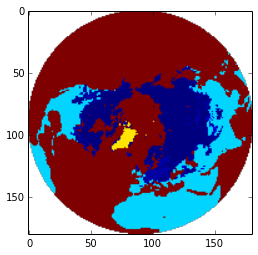

In [13]:
d = nc.Dataset(test_basename+'.nc')
snow = d.variables['merged_snow_cover_extent'][:]
lats = d.variables['latitude'][:]
lons = d.variables['longitude'][:]
plt.imshow(snow[0,...])

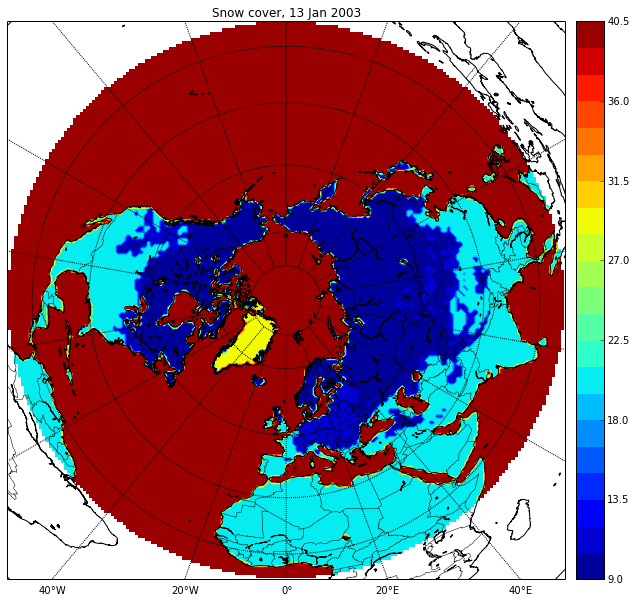

In [14]:
plt.figure(figsize=(12,10))
m = init_basemap()
c = m.contourf(lons[:], lats[:],
               snow[0,...], 20, latlon=True)
cb = m.colorbar(c)
plt.title("Snow cover, 13 Jan 2003")

In [15]:
d.close()

<i>Notes on specific versions and details of what we tested:
1. The geotiff file I create here geolocates correctly in envi 5.2 and envi -classic.
2. The .nc file I create here does not geolocate correctly in envi 5.2; Terry speculates that envi may not yet be ready for prime time with netCDF)
3. The geotiff file I create here imports into ArcMAP 10.1 without complaint, and I can correctly overlay GSHHS global coastlines on it, as well as reproject it to the global Robinson projection.
4. We used gdalinfo and gdal_translate versions from GDAL 1.11.2, released 2015/02/10
</i>